# Practical session on Adversarial Machine Learning
**Summer School Cyber in Font-Romeu**

July 9th 2025

### Imports and parameters

In [300]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
# For some reason, we need to run this
tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()

from keras.models import load_model
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BoundaryAttack
from art.defences.detector.evasion import BinaryInputDetector
from art.defences.trainer import AdversarialTrainer

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utils import random_subsample, show_images, plot_images_pca, create_model_cifar, load_cifar100_file, plot_adversarial_comparison

In [301]:
TARGET_CLASS=b'people'

In [302]:
#SOLUTION

LOAD_MODEL = 0 # Choose if you want to create a classifier model, or load it from a previous file
LOAD_MODEL_ADV = 0 # Choose if you want to create a classifier model, or load it from a previous file

In [303]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Adversarial machine learning: the science of fooling machine learning models.

The two main aspects of adversarial machine learning are:
1. **Attacks:** Techniques to generate inputs that cause a model to make wrong predictions with high confidence. These can be:
    - Evasion attacks (modifying inputs at test time, e.g., adding small perturbations to images to fool a classifier),
    - Poisoning attacks (manipulating the training data to embed vulnerabilities),
    - Exploratory attacks (extracting information about the model, e.g., through model inversion or membership inference).
2. **Defenses:** Strategies to make models more robust or to detect threats. Examples include
    - adversarial training (training on perturbed data),
    - detection of poisoning and adversarial examples,
    - certified robustness approaches.

Note that poisoning, membership inference and the like where explained by Josep Domingo Ferrer on monday.

<img src="https://raw.githubusercontent.com/Trusted-AI/adversarial-robustness-toolbox/refs/heads/main/docs/images/white_hat_blue_red.png" alt="Red and Blue teams for Adversarial ML" width = 400/>

In this session, we will use the Adversarial Robustness Toolbox (ART) developed by IBM: https://github.com/Trusted-AI/adversarial-robustness-toolbox
- It supports multiple attack and defense algorithms,
- It is actively maintained and well-documented,
- It works with major deep learning frameworks (TensorFlow, PyTorch, Keras).

*Comparative table of the main adversarial ML libraries*
| Library | Supported Frameworks | Attacks & Defenses | Ease of Use | Actively | Maintained |
| --- | --- | --- | --- | --- | --- |
| Adversarial Robustness Toolbox (ART) | TensorFlow, PyTorch, Keras, MXNet | Many (FGSM, PGD, CW, etc.) | Many | High | ✅|
| CleverHans | TensorFlow, PyTorch | Evasion (many), less focus on defenses | Few | Moderate | ⚠️ (less active)|
| Foolbox | TensorFlow, PyTorch | Wide variety (esp. evasion) | Limited | High | ✅|
| Advertorch | PyTorch | Evasion-focused | Some defenses | High | ⚠️ (slightly less active)|
| DeepRobust | PyTorch | Evasion, poisoning | Several | Moderate | ✅ |

# Part 1: The classification of images with a class "people"

## 1.1 Dataset: CIFAR100

We use here the CIFAR-100 dataset, a well-known benchmark dataset for image classification tasks.

*What is in CIFAR-100?*
- It contains 60,000 color images of size 32×32 pixels.
- Each image belongs to one of 100 classes (for example, apple, castle, lion).
- These 100 fine classes are grouped into 20 super classes, which represent more general categories (for example, food containers, large carnivores, people).

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240522153720/download.png" alt="CIFAR100" width = 250/>

The dataset is split as follows:
- 50,000 training images
- 10,000 test images

*Focus on the “people” class*

Among the 20 super classes, there is a group called “people”, which gathers all images containing humans.

In this session, we will focus on attacking this "people" class.
Our goal is to study how adversarial examples can mislead a model into misclassifying images of people.

### Load raw dataset
- The dataset can be loaded using the *load_cifar100_file()* function from *utils.py*, see its perfectly written docstring.
- you should obtain at least *x_train, y_train, x_test, y_test*: the training/test data x and labels y.
- *classes* gives you the different classes for the dataset with the 20 super classes.
- **In order to have more efficient models, you should change the classes in order to have only people vs. things.**

In [304]:
#TODO


In [305]:
# #SOLUTION (download the full data)

# (x_train, y_train_fine), (x_test, y_test_fine), min_, max_, fine_classes = load_cifar100(fine_or_coarse=0)
# y_train_fine = np.array(y_train_fine); y_test_fine = np.array(y_test_fine)
# y_train_fine_ind = np.argmax(y_train_fine, axis=1); y_test_fine_ind = np.argmax(y_test_fine, axis=1)
# y_train_fine_class = np.array([fine_classes[y] for y in y_train_fine_ind]); y_test_fine_class = np.array([fine_classes[y] for y in y_test_fine_ind])

# (x_train, y_train), (x_test, y_test), min_, max_, classes = load_cifar100(fine_or_coarse=1)
# x_train = np.array(x_train); x_test = np.array(x_test);
# y_train = np.array(y_train); y_test = np.array(y_test)
# y_train_ind = np.argmax(y_train, axis=1); y_test_ind = np.argmax(y_test, axis=1)
# y_train_class = np.array([classes[y] for y in y_train_ind]); y_test_class = np.array([classes[y] for y in y_test_ind])

# with open('data_handson_aml.pkl', 'wb') as file:
#     pickle.dump([(x_train, y_train), (x_test, y_test), min_, max_, classes], file)

In [306]:
#SOLUTION

(x_train, y_train), (x_test, y_test), min_, max_, classes = load_cifar100_file()
y_train_ind = np.argmax(y_train, axis=1); y_test_ind = np.argmax(y_test, axis=1)
y_train_class = np.array([classes[y] for y in y_train_ind]); y_test_class = np.array([classes[y] for y in y_test_ind])

In [307]:
#SOLUTION

ind_people = classes.index(b'people')
classes=[b'people', b'things']
y_train = np.array([[1, 0] if y[ind_people] else [0, 1] for y in y_train])
y_test = np.array([[1, 0] if y[ind_people] else [0, 1] for y in y_test])
y_train_ind = np.argmax(y_train, axis=1); y_test_ind = np.argmax(y_test, axis=1)
y_train_class = np.array([b'people' if not y else b'things' for y in y_train_ind])
y_test_class = np.array([b'people' if not y else b'things' for y in y_train_ind])

### Balance the dataset for training
- **restore the balance**: If you have changed to "people" or "things", the instances of each class are now unbalanced. Randomly select a subset of the "things" examples of the same size as the "people".
- Having balanced datasets for training is crucial, else you are building an algorithmic bias.

In [308]:
#TODO


In [309]:
#SOLUTION

train_people_idx = np.where(y_train_ind == 0)[0]
train_things_idx = np.where(y_train_ind == 1)[0]
num_people = len(train_people_idx)
np.random.seed(42)
selected_things_idx = np.random.choice(train_things_idx, size=num_people, replace=False)
# extra_things_idx = np.setdiff1d(train_things_idx, selected_things_idx)

# New train set
new_train_idx = np.concatenate([train_people_idx, selected_things_idx])
x_train = x_train[new_train_idx]
y_train = y_train[new_train_idx]
y_train_ind = y_train_ind[new_train_idx]
y_train_class = y_train_class[new_train_idx]

# New test set
test_people_idx = np.where(y_test_ind == 0)[0]
test_things_idx = np.where(y_test_ind == 1)[0]
num_people = len(test_people_idx)
np.random.seed(42)
selected_things_idx = np.random.choice(test_things_idx, size=num_people, replace=False)
extra_things_idx = np.setdiff1d(test_things_idx, selected_things_idx)

# New test set
new_test_idx = np.concatenate([test_people_idx, selected_things_idx])
x_test = x_test[new_test_idx]
y_test = y_test[new_test_idx]
y_test_ind = y_test_ind[new_test_idx]
y_test_class = y_test_class[new_test_idx]

<!-- - Optionnaly: you can select a random subset to decrease the size of the training and test datasets. You can use random_subsample from utils... But everything is fine. -->

In [310]:
#TODO (Optionnal)

In [311]:
#SOLUTION (fine)

# [x_train, y_train_fine, y_train_fine_ind, y_train_fine_class, y_train, \
#     y_train_ind, y_train_class] = random_subsample([x_train, y_train_fine, \
#     y_train_fine_ind, y_train_fine_class, y_train, y_train_ind, y_train_class], \
#     n=SUBSAMPLE_TRAIN_SIZE)

# [x_test, y_test_fine, y_test_fine_ind, y_test_fine_class, y_test, y_test_ind, \
#     y_test_class] = random_subsample([x_test, y_test_fine, y_test_fine_ind, \
#     y_test_fine_class, y_test, y_test_ind, y_test_class], n=SUBSAMPLE_TEST_SIZE)

In [312]:
# #SOLUTION

# [x_train, y_train, y_train_ind, y_train_class] = random_subsample([x_train, \
#     y_train, y_train_ind, y_train_class], n=SUBSAMPLE_TRAIN_SIZE)

# [x_test, y_test, y_test_ind, y_test_class] = random_subsample([x_test, y_test, \
#     y_test_ind, y_test_class], n=SUBSAMPLE_TEST_SIZE)

In [313]:
print(f"Number of Training examples: {len(y_train)}")
print(f"Number of Test examples: {len(y_test)}")
print(f"Number of classes: {len(classes)}")

Number of Training examples: 840
Number of Test examples: 214
Number of classes: 2


### Visualize some images
One can use the show_images function from utils.py.

In [314]:
#TODO


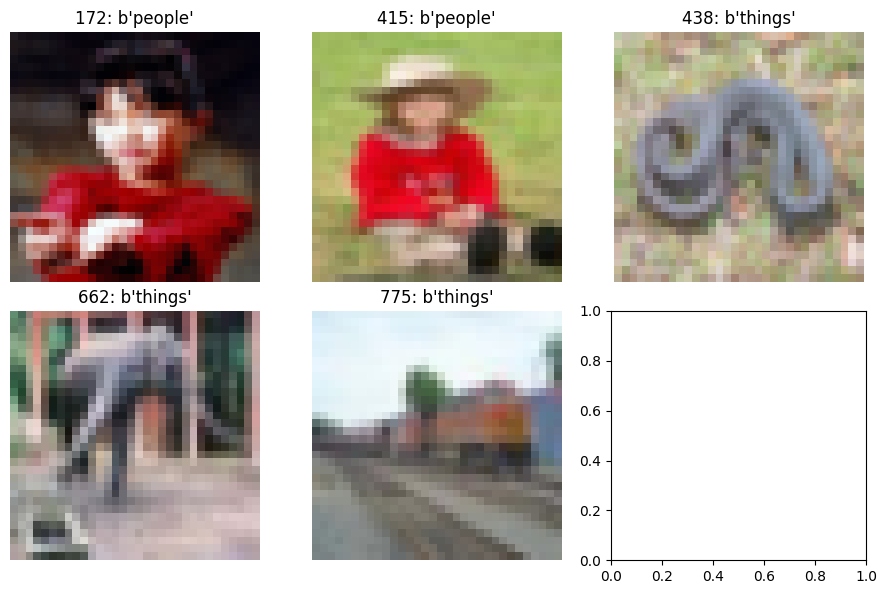

In [315]:
#SOLUTION

# show_images(x_train, y_train_class, y_fine=y_train_fine_class, n=5)
show_images(x_train, y_train_class, n=5)

### Visualize the dataset
- use dimensional reduction with PCA and plot the pictures in 2D
- plot the distribution of classes in the training and test datasets

In [316]:
#TODO


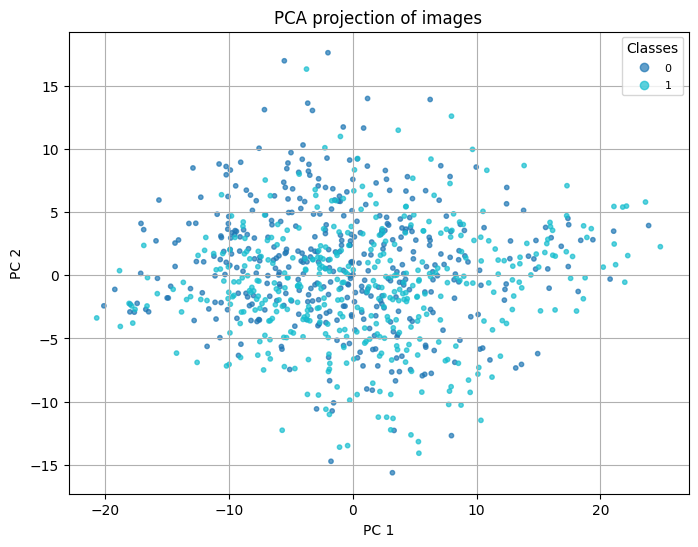

In [317]:
#SOLUTION

plot_images_pca(x_train, y_train_ind)

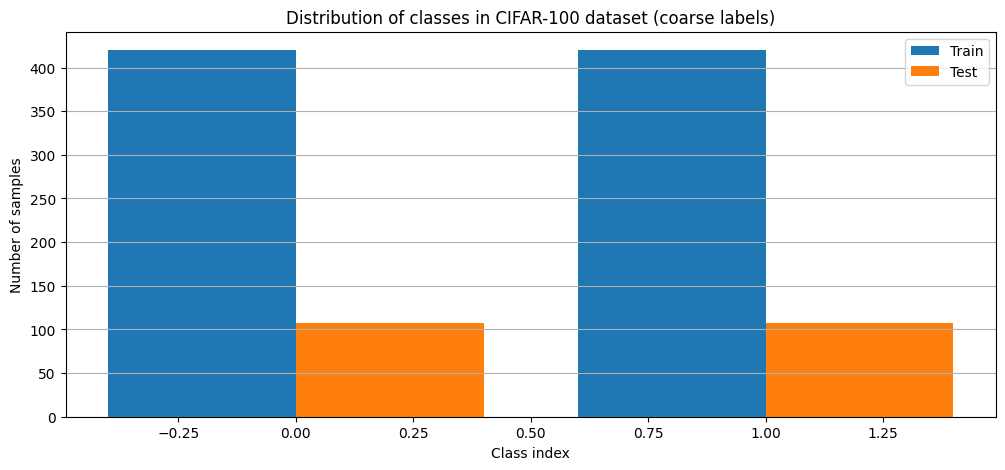

In [318]:
#SOLUTION

train_counts = np.bincount(y_train_ind)
test_counts = np.bincount(y_test_ind)
num_classes = len(train_counts)

plt.figure(figsize=(12, 5))

plt.bar(np.arange(num_classes) - 0.2, train_counts, width=0.4, label='Train')
plt.bar(np.arange(num_classes) + 0.2, test_counts, width=0.4, label='Test')

plt.xlabel("Class index")
plt.ylabel("Number of samples")
plt.title("Distribution of classes in CIFAR-100 dataset (coarse labels)")
plt.legend()
plt.grid(axis='y')
plt.show()

## 1.2 Our classification model: a classical CNN
We use a simple Convolutional Neural Network (CNN) architecture with:
- 3 convolutional blocks (each: convolution, max-pooling, dropout)
- 2 dense layers (one hidden layer + final output layer)

CNNs are the standard choice for image analysis, as they efficiently capture spatial patterns.
Here, a small architecture is sufficient since our images are small (32×32) and we only have 2 classes ("people" and "things").

### Create the model
- Study the function create_model_cifar from utils.py
- Use it to create your model

In [319]:
#TODO

In [320]:
from keras import layers, models

model = create_model_cifar(num_classes=len(classes))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 13, 13, 32)      

### Fine-tune the model for the particular data
- This can be done with a simple call to the *fit* method of the model, look for the documentation of Tensorflow or examples: https://www.geeksforgeeks.org/deep-learning/model-fit-in-tensorflow/.
- Note that the images are already normalized: pixel values are between 0 and 1 so no preprocessing to do.

In [321]:
#TODO


In [341]:
#SOLUTION

if LOAD_MODEL:
    classifier = load_model("./classifier.h5")

if not LOAD_MODEL:
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=128)

    model.save("./classifier.h5")

Epoch 1/5
7/7 [==============================] - 0s 29ms/step - loss: 0.1249 - accuracy: 0.9512 - val_loss: 0.6147 - val_accuracy: 0.7757
Epoch 2/5
7/7 [==============================] - 0s 29ms/step - loss: 0.1417 - accuracy: 0.9405 - val_loss: 0.7504 - val_accuracy: 0.7850
Epoch 3/5
7/7 [==============================] - 0s 28ms/step - loss: 0.1022 - accuracy: 0.9643 - val_loss: 0.7171 - val_accuracy: 0.7897
Epoch 4/5
7/7 [==============================] - 0s 29ms/step - loss: 0.1045 - accuracy: 0.9571 - val_loss: 0.6534 - val_accuracy: 0.7897
Epoch 5/5
7/7 [==============================] - 0s 28ms/step - loss: 0.1122 - accuracy: 0.9607 - val_loss: 0.8502 - val_accuracy: 0.7664


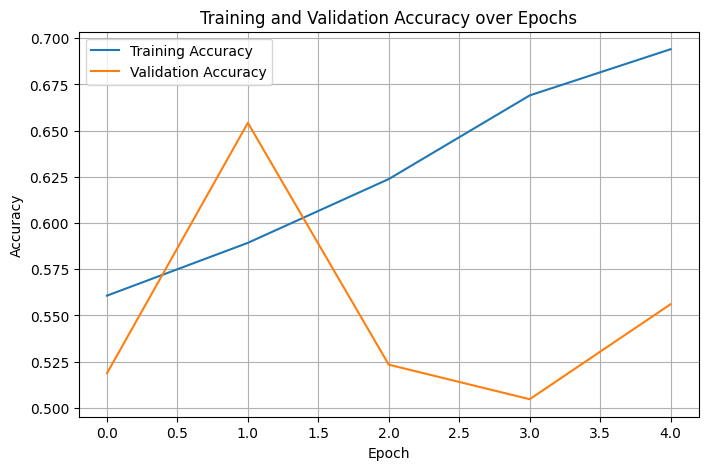

In [323]:
#SOLUTION

if not LOAD_MODEL:
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

## 1.3 Finally, let's start using ART ! Adversarial-Robustness Toolbox
A key idea behind ART is that it adopts an agnostic approach with respect to the underlying machine learning library.
This means ART is designed to work seamlessly with models implemented in different frameworks (e.g. Tensorflow, Pytorch, Scikit-learn)

*Why do we wrap models?*: In our case (using TensorFlow 2.x and Keras), we use:  **from art.estimators.classification import TensorFlowV2Classifier**. This wrapper converts our TensorFlow model into a generic ART classifier, which provides a unified API for: training, evaluation, adversarial example generation, defense setup, etc.

*Remark:* We could have chosen to wrap the model first, and then do the fine-tuning on the ART classifier object. In fact, we will now check the accuracy of the fine-tuned model using this interface.

In [346]:
classifier = TensorFlowV2Classifier(clip_values=(min_, max_), model=model, \
    loss_object=CategoricalCrossentropy(), optimizer=Adam(), nb_classes=len(classes), \
    input_shape=x_train[0].shape, preprocessing=(0, 1)
)

### Check the accuracy of the model on the train and test set
- By applying the *predict* method of the classifier, and comparing with the truth for all the examples, you can get the overall accuracy for both datasets.

In [347]:
#TODO

In [348]:
#SOLUTION

y_train_pred = np.argmax(classifier.predict(x_train), axis=1)
acc_train = np.sum(y_train_pred == y_train_ind)/len(y_train)
y_test_pred = np.argmax(classifier.predict(x_test), axis=1)
acc_test = np.sum(y_test_pred == y_test_ind)/len(y_test)

print("Dataset training vs. test:")
print(f"size: {len(y_train)} / {len(y_test)} images")
print(f"accuracy: {acc_train*100} / {acc_test*100} %")
# print(f"Dataset test: {acc_test}% for {len(y_test)} images")

Dataset training vs. test:
size: 840 / 214 images
accuracy: 96.54761904761905 / 76.63551401869158 %


- Compute the confusion matrix for the test set (you can use *scikit-learn.metrics*)

In [349]:
#TODO


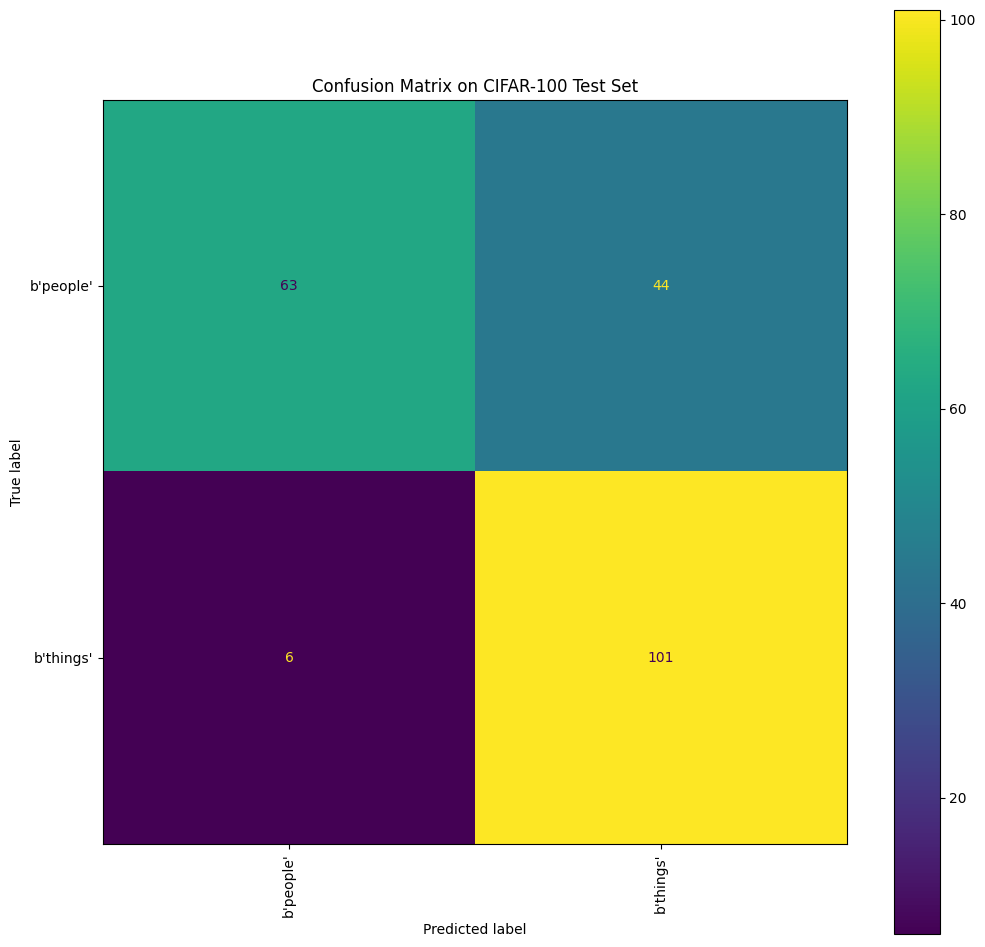

In [350]:
#SOLUTION

cm = confusion_matrix(y_test_ind, y_test_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix on CIFAR-100 Test Set")
plt.show()

- Test the model on a picture of your choice (resize it to 32x32, /255) and/or images from the test set

In [351]:
# TODO


1/1 [==============================] - 0s 11ms/step
(2,)
(2, 32, 32, 3)


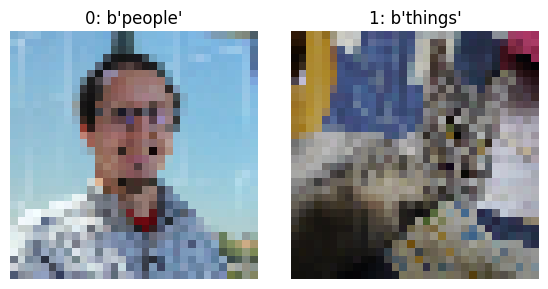

In [352]:
#SOLUTION

from tensorflow.keras.preprocessing import image
import math
import random as rd

preds = []
imgs = []
for img_path in ["/home/pleleux/Bureau/Adversarial/Leleu-IMG_5960-600_600.jpg",
        "/home/pleleux/Images/Wallpapers/P1170537.JPG"]:
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    preds.append(classes[np.argmax(model.predict(img_array), axis=1)[0]])
    
    imgs.append(img_array[0,:,:,:])
preds = np.array(preds)
imgs = np.array(imgs)
print(preds.shape)
print(imgs.shape)

show_images(imgs, preds, n=4, n_cols=2)

# Part 2: Attack on machines
In this part, we focus on **evasion attacks**, where the attacker modifies inputs at test time to fool the classifier:
- **FGSM**, **PGD**: **white-box attacks**, where the attacker has full knowledge of the model.
- **Boundary Attack**: **black-box attack**, where the attacker can only query the model without knowing its details.

Here, we show but a few example attacks. Many more are available:
[ART attacks list](https://github.com/Trusted-AI/adversarial-robustness-toolbox/wiki/ART-Attacks)


## 2.2 FGSM (Fast Gradient Sign Method)
One of the simplest and most popular adversarial attack techniques. 
The idea is to create a small perturbation that pushes the input in the direction that maximally increases the model's loss.

The resulting perturbation is very small (almost imperceptible to the human eye), but can significantly change the model's prediction.


<img src="https://miro.medium.com/v2/resize:fit:1043/1*7BgNv9c2n7KNq3rrUcfZ8A.png" alt="Red and Blue teams for Adversarial ML" width = 500/>

See [Goodfellow et al., 2015](https://arxiv.org/abs/1412.6572).

### Generation of adversarial examples
In order to apply FGSM in ART (see notebooks/adversarial_training_mnist.ipynb for an example):
- create an object *FastGradientMethod*
- use its method *generate* for the genration of the adversarial examples based on the test set
- visualize the original image with its adversarial counterpart and the noise. One can use *plot_adversarial_comparison* from utils.py.

In [353]:
#TODO


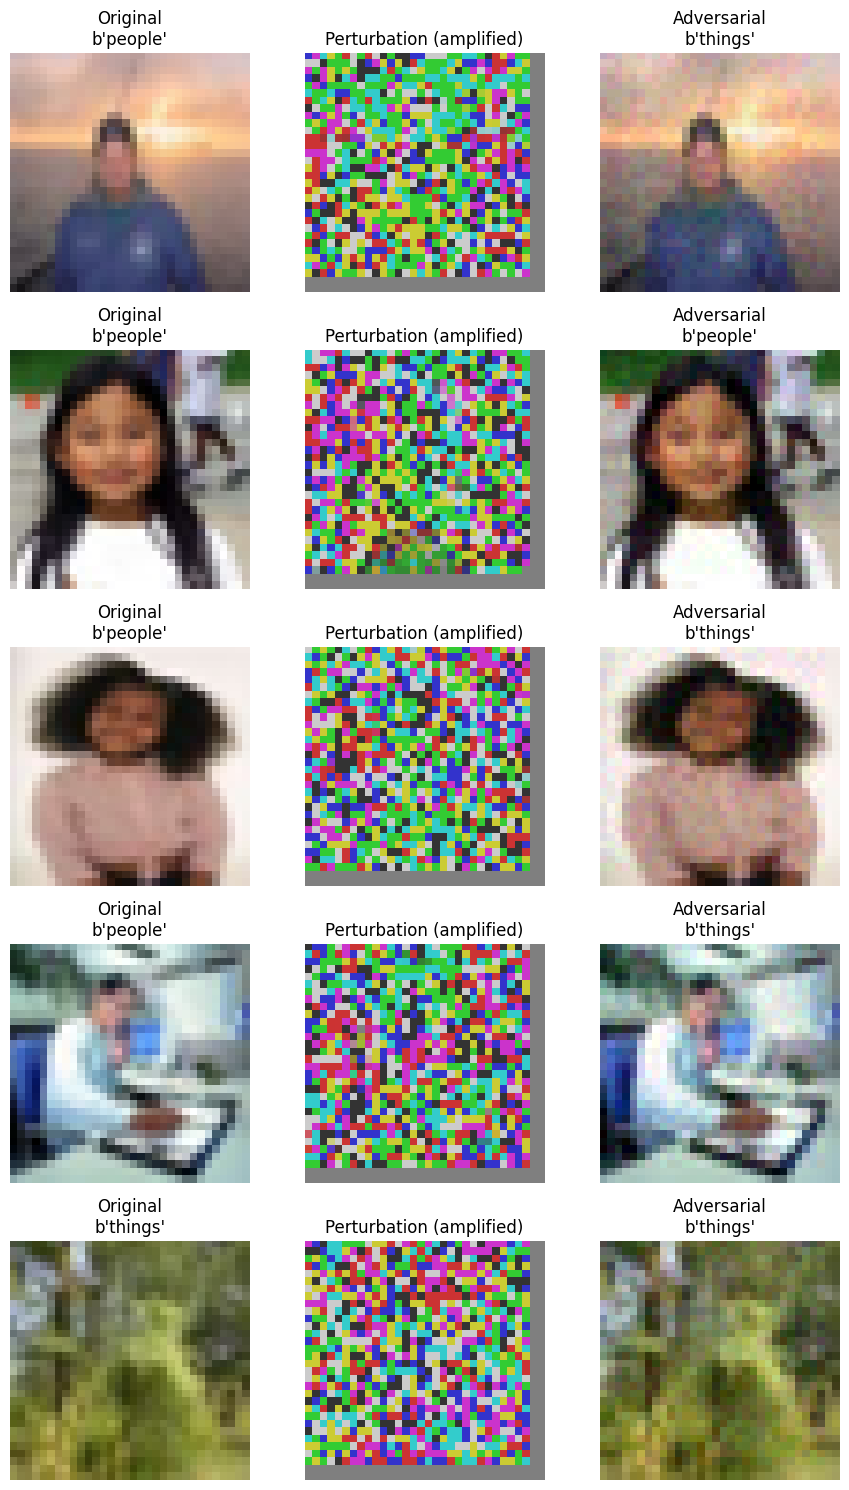

In [354]:
#SOLUTION

attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.03)
x_test_adv = attack_fgsm.generate(x=x_test)

plot_adversarial_comparison(classifier, x_test, x_test_adv, classes)

### Impact on the model accuracy
- compute the accuracy on the model for the original test set and the adversarial examples.
- try to have the parameter epsilon vary from 0 to 0.2, plot the impact on these accuracies.

In [355]:
#TODO


In [356]:
#SOLUTION

preds_clean = np.argmax(classifier.predict(x_test), axis=1)
preds_adv = np.argmax(classifier.predict(x_test_adv), axis=1)
true_labels = np.argmax(y_test, axis=1)

acc_clean = np.sum(preds_clean == true_labels) / len(true_labels)
acc_adv = np.sum(preds_adv == true_labels) / len(true_labels)

print(f"Accuracy on clean examples: {acc_clean*100:.2f}%")
print(f"Accuracy on adversarial examples (FGSM): {acc_adv*100:.2f}%")


Accuracy on clean examples: 76.64%
Accuracy on adversarial examples (FGSM): 45.79%


Running FGSM
epsilon: accuracy clean vs. adversarial
0.0: 76.64% vs. 76.64%
0.01: 76.64% vs. 62.62%
0.02: 76.64% vs. 50.00%
0.03: 76.64% vs. 45.79%
0.05: 76.64% vs. 39.72%
0.1: 76.64% vs. 37.85%
0.2: 76.64% vs. 39.25%


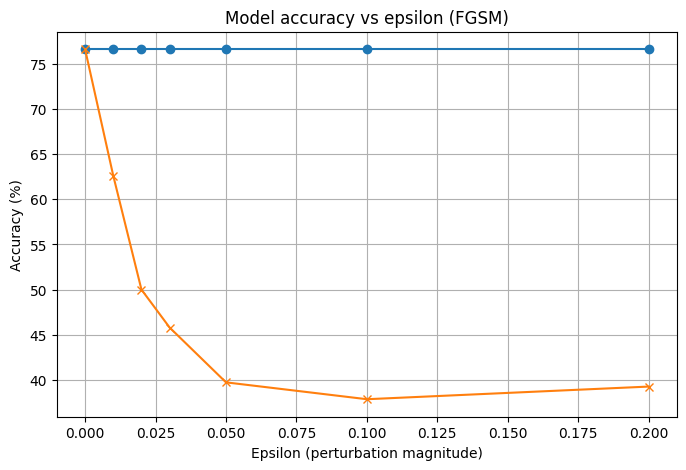

In [357]:
#SOLUTION

epsilons = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]

acc_clean = []
acc_adv = []
print(f"Running FGSM")
print(f"epsilon: accuracy clean vs. adversarial")
for eps in epsilons:    
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    
    x_test_adv = attack_fgsm.generate(x=x_test)
    
    preds_clean = np.argmax(classifier.predict(x_test), axis=1)
    preds_adv = np.argmax(classifier.predict(x_test_adv), axis=1)
    true_labels = np.argmax(y_test, axis=1)

    acc_clean.append(np.sum(preds_clean == true_labels) / len(true_labels))
    acc_adv.append(np.sum(preds_adv == true_labels) / len(true_labels))

    print(f"{eps}: {acc_clean[-1]*100:.2f}% vs. {acc_adv[-1]*100:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(epsilons, [a * 100 for a in acc_clean], marker='o')
plt.plot(epsilons, [a * 100 for a in acc_adv], marker='x')
plt.title("Model accuracy vs epsilon (FGSM)")
plt.xlabel("Epsilon (perturbation magnitude)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

**Questions:**
- How doeas the accuracy evolve with epsilon ?
- For the attacker, what is the risk of using high values for epsilon ?

## 2.3 Projected Gradient Descent (PGD)
The **Projected Gradient Descent (PGD)** attack is one of the most powerful and widely used to evaluate model robustness.

PGD can be seen as a stronger, multi-step version of FGSM. Instead of applying a single large gradient step, PGD takes multiple small steps, each time moving slightly in the direction that increases the loss. After each step, the perturbed image is **projected back** into a valid range around the original image, to keep the perturbation small.

By iterating and projecting, PGD finds more effective adversarial examples than single-step methods like FGSM.


<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ4RpYZnPeRzILqJAA1wnPXk8361OW6lpukcA&s" alt="Red and Blue teams for Adversarial ML" width = 500/>

See [Madry et al., 2018](https://arxiv.org/pdf/1706.06083).

### Generation and test
- Do the same as FSGM !

In [358]:
#TODO


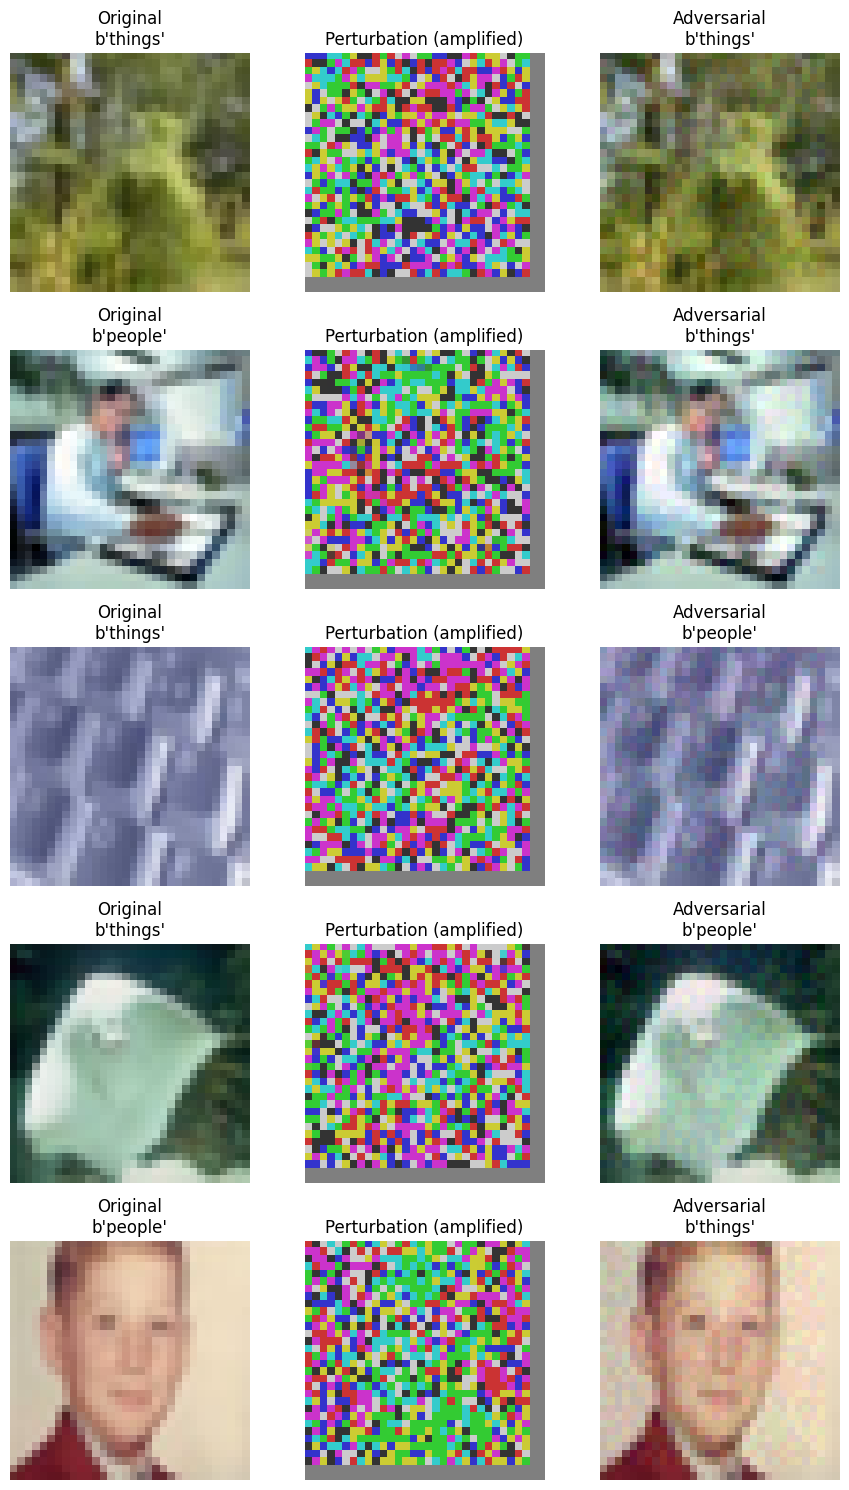

In [359]:
#SOLUTION

attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.03, max_iter=40)
x_test_adv = attack_pgd.generate(x=x_test)

plot_adversarial_comparison(classifier, x_test, x_test_adv, classes)

Running PGD
epsilon: accuracy clean vs. adversarial


0.0: 76.64% vs. 76.64%


0.01: 76.64% vs. 66.82%


0.02: 76.64% vs. 51.87%


0.03: 76.64% vs. 45.79%


0.05: 76.64% vs. 41.59%


0.1: 76.64% vs. 23.36%


0.2: 76.64% vs. 23.36%


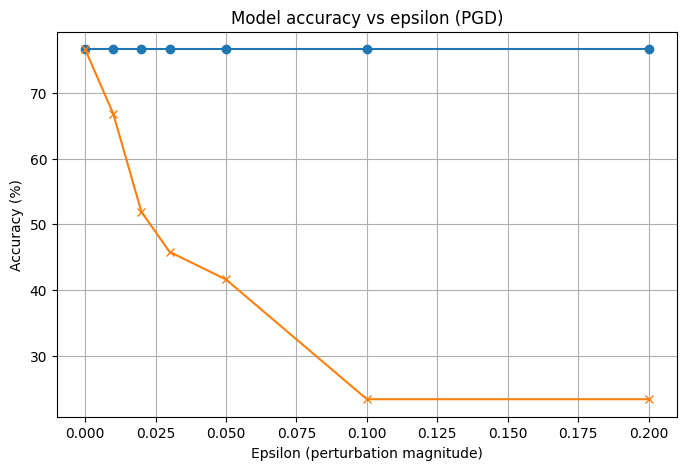

In [360]:
#SOLUTION

epsilons = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]

acc_clean = []
acc_adv = []
print(f"Running PGD")
print(f"epsilon: accuracy clean vs. adversarial")
for eps in epsilons:    
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=eps, max_iter=40)
    x_test_adv = attack_pgd.generate(x=x_test)
    
    preds_clean = np.argmax(classifier.predict(x_test), axis=1)
    preds_adv = np.argmax(classifier.predict(x_test_adv), axis=1)
    true_labels = np.argmax(y_test, axis=1)

    acc_clean.append(np.sum(preds_clean == true_labels) / len(true_labels))
    acc_adv.append(np.sum(preds_adv == true_labels) / len(true_labels))

    print(f"{eps}: {acc_clean[-1]*100:.2f}% vs. {acc_adv[-1]*100:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(epsilons, [a * 100 for a in acc_clean], marker='o')
plt.plot(epsilons, [a * 100 for a in acc_adv], marker='x')
plt.title("Model accuracy vs epsilon (PGD)")
plt.xlabel("Epsilon (perturbation magnitude)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

###  Generate targetted adversarial examples
It is possible to specify what class you want to be predicted for the adversarial example: targetted adversarial examples.
In terms of the algorithm, we follow the inverse direction of the gradient, which will decrease the loss for the targeted label.
This is close to the classical gradient descent for training.

Generat target adversarial examples:
- This can be done with
    - the argument *targeted=True* in *ProjectedGradientDescent*
    - the argument *y* in *generate* which gives the wanted label(s)
- Compute the predictions for the entire adversarial dataset and display the confusion matrix

In [361]:
#TODO


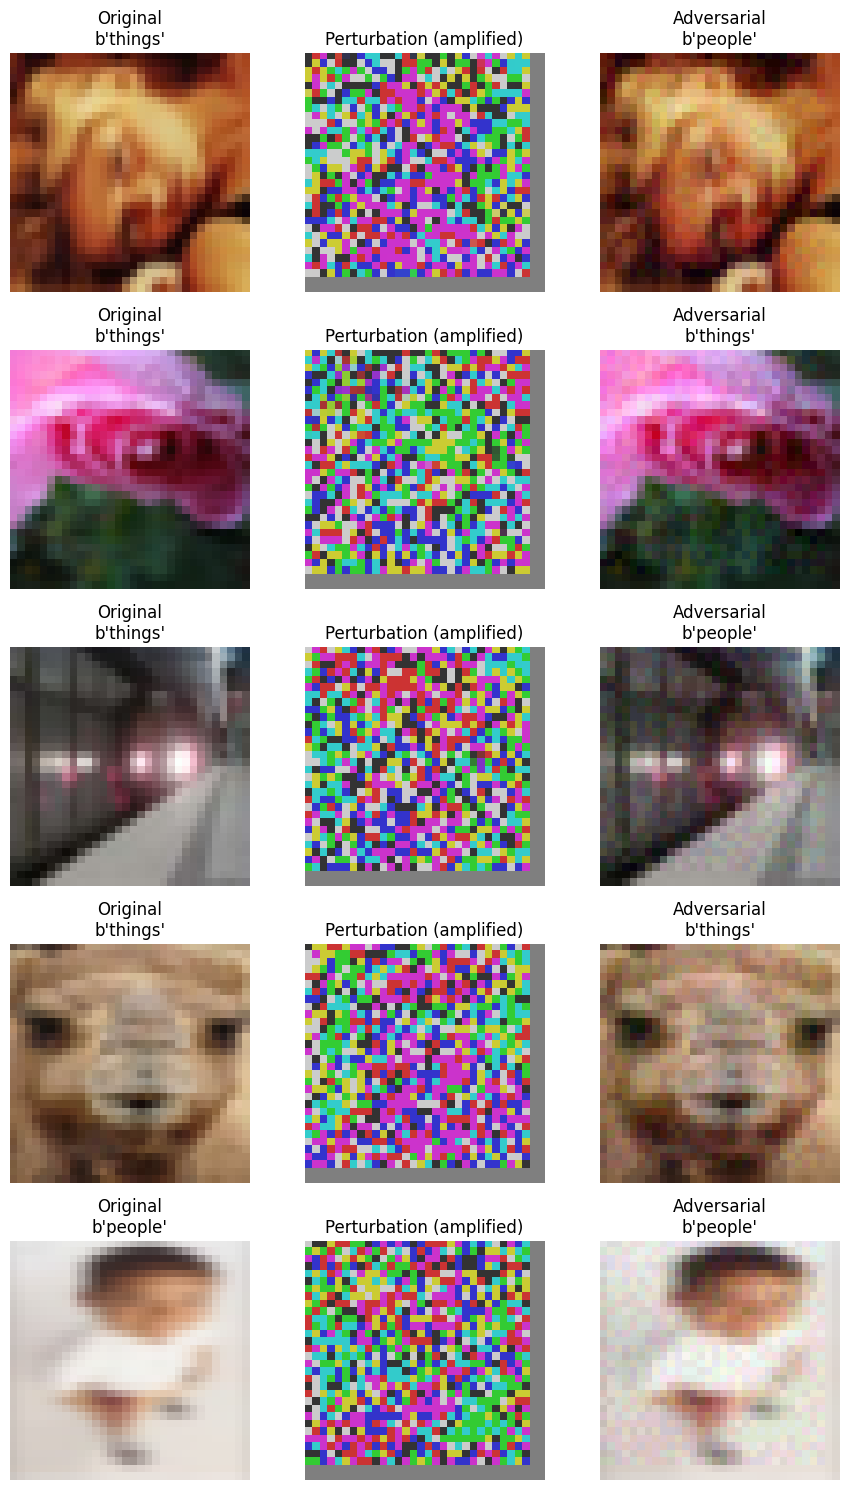

In [362]:
#SOLUTION

target_labels = np.ones(len(x_test), dtype=np.int64) * classes.index(TARGET_CLASS)
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.03, max_iter=40, targeted=True)
x_test_adv = attack_pgd.generate(x=x_test, y=target_labels)

plot_adversarial_comparison(classifier, x_test, x_test_adv, classes)

Test accuracy on the test set: 70.09%


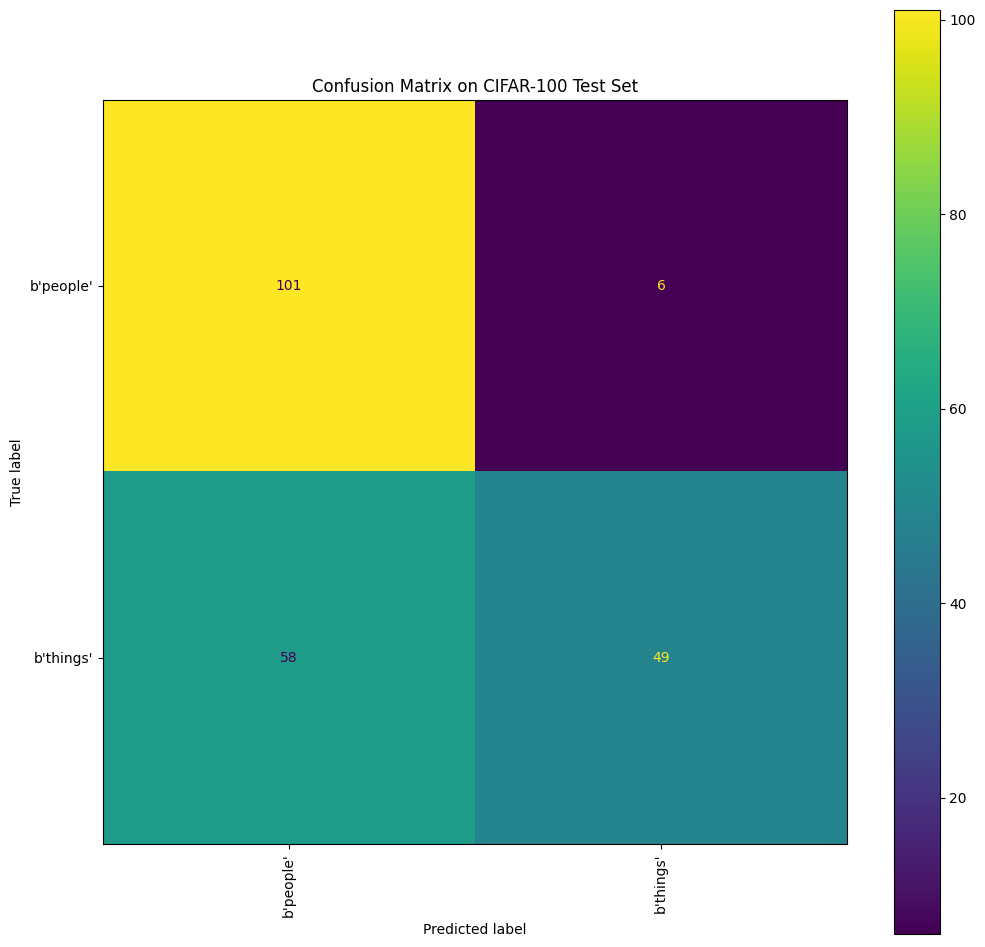

In [363]:
#SOLUTION

preds_adv = np.argmax(classifier.predict(x_test_adv), axis=1)

accuracy = np.mean(preds_adv == true_labels)
print(f"Test accuracy on the test set: {accuracy * 100:.2f}%")

cm = confusion_matrix(true_labels, preds_adv)
# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix on CIFAR-100 Test Set")
plt.show()

Running PGD
epsilon: accuracy clean vs. adversarial


0.0: 76.64% vs. 76.64%


0.01: 76.64% vs. 78.97%


0.02: 76.64% vs. 72.90%


0.03: 76.64% vs. 70.09%


0.05: 76.64% vs. 67.76%


0.1: 76.64% vs. 50.00%


0.2: 76.64% vs. 50.00%


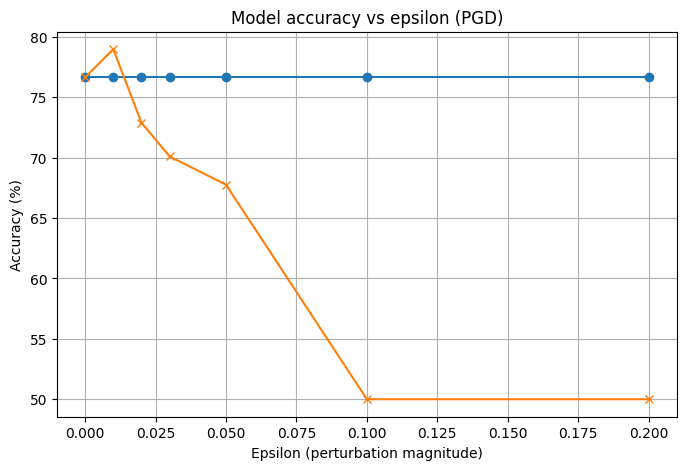

In [364]:
#SOLUTION

epsilons = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]

acc_clean = []
acc_adv = []
target_labels = np.ones(len(x_test), dtype=np.int64) * classes.index(TARGET_CLASS)
print(f"Running PGD")
print(f"epsilon: accuracy clean vs. adversarial")
for eps in epsilons:    
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=eps, max_iter=40, targeted=True)
    x_test_adv = attack_pgd.generate(x=x_test, y=target_labels)
    
    preds_clean = np.argmax(classifier.predict(x_test), axis=1)
    preds_adv = np.argmax(classifier.predict(x_test_adv), axis=1)
    true_labels = np.argmax(y_test, axis=1)

    acc_clean.append(np.sum(preds_clean == true_labels) / len(true_labels))
    acc_adv.append(np.sum(preds_adv == true_labels) / len(true_labels))

    print(f"{eps}: {acc_clean[-1]*100:.2f}% vs. {acc_adv[-1]*100:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(epsilons, [a * 100 for a in acc_clean], marker='o')
plt.plot(epsilons, [a * 100 for a in acc_adv], marker='x')
plt.title("Model accuracy vs epsilon (PGD)")
plt.xlabel("Epsilon (perturbation magnitude)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

**Questions:**
- Does the confusion matrix reflect the effect of the target adversarial generation ?

## 2.3 Black Box: Boundary Attack 
This is a black-box evasion attack: this attack **only needs to query the model and observe the output label**. We do not need to know the model's parameters or architecture.

The idea is to start from a **large initial adversarial example** (e.g., pure noise or an image that is already misclassified) and then **iteratively reduce the perturbation** while keeping the image adversarial.
The algorithm moves toward the original image while staying on the "wrong side" of the decision boundary. This way, it progressively finds a minimally perturbed adversarial example.

The attack can also be **targeted**, meaning it aims to change the prediction to a specific target class instead of just any incorrect class.

See a [nice explanation here](https://github.com/greentfrapp/boundary-attack) and the original paper [Brendel et al. 2018](https://arxiv.org/abs/1712.04248).

### Setting up the attack
It is a bit complicated to set up.
If you still have a lot of time, I advise looking at "notebooks/attack_decision_based_boundary.ipynb".
Else, you can get to the next part.


In [365]:
init_image_ind = 171
target_image_ind = 735
init_image=np.array([x_train[init_image_ind]])
target_image=np.array([x_train[target_image_ind]])

In [366]:
#TODO


1/1 [==============================] - 0s 11ms/step


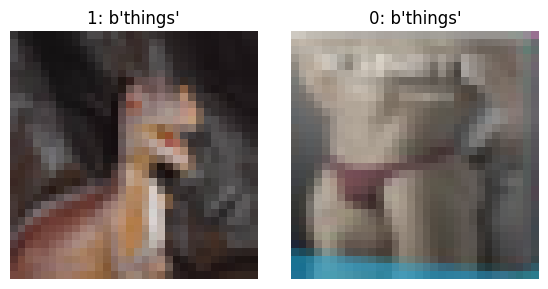

In [367]:
#SOLUTION

preds = []
imgs = np.array(np.concatenate((init_image, target_image)))
for x in imgs:
    preds.append(classes[np.argmax(model.predict(imgs), axis=1)[0]])

show_images(imgs, preds, n=2, n_cols=2)

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

Adversarial image at step 0. L2 error: 0.00, Class label: 1, Class name: b'things'


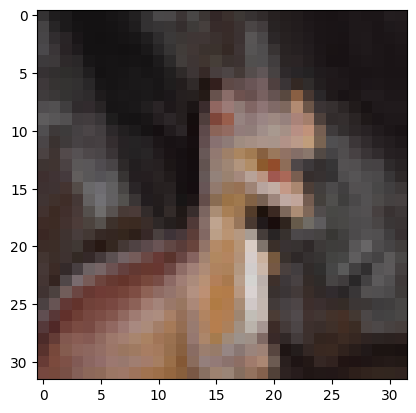

In [368]:
#SOLUTION

attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 200
x_adv = None

for i in range(21):
    x_adv = attack.generate(x=target_image, x_adv_init=x_adv)

    l2_error = np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1]))
    class_label = np.argmax(classifier.predict(x_adv)[0])
    class_name = classes[class_label]

    print("Adversarial image at step %d. L2 error: %.2f, Class label: %d, Class name: %s" %
     (i * iter_step, l2_error, class_label, class_name))

    if not i % 5:
        plt.imshow(x_adv[0])
        plt.show(block=False)

    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

Adversarial image at step 0. L2 error: 0.00, Class label: 1, Class name: b'things'


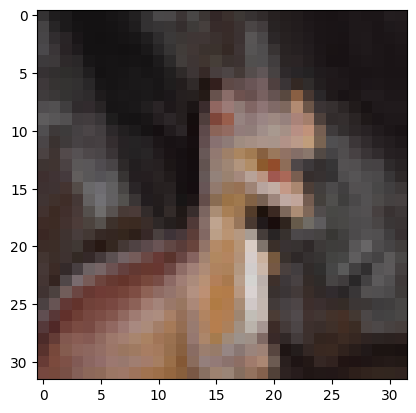

In [369]:
#SOLUTION

attack = BoundaryAttack(estimator=classifier, targeted=True, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 200
x_adv = init_image

for i in range(21):
    y_to_categorical = np.array([0 if i==classes.index(TARGET_CLASS) else 1 for i in range(len(classes))])
    x_adv = attack.generate(x=target_image, x_adv_init=np.array([x_adv[0]]), y=y_to_categorical)

    l2_error = np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1]))
    class_label = np.argmax(classifier.predict(x_adv)[0])
    class_name = classes[class_label]

    print("Adversarial image at step %d. L2 error: %.2f, Class label: %d, Class name: %s" %
     (i * iter_step, l2_error, class_label, class_name))

    if not i % 5:
        plt.imshow(x_adv[0])
        plt.show(block=False)

    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

# Part 3: Defending againt the machine
- We start with **detection**, which aims to identify whether an input is adversarial or clean before making a prediction.
- Then, we explore **adversarial training**, where the model is trained on adversarial examples to improve its robustness.

Again, these are just a few example approaches, but other defense methods are available in ART:
[ART defenses list](https://github.com/Trusted-AI/adversarial-robustness-toolbox/wiki/ART-Defences)

## 3.1 Detector based on the inputs
Detecting adversarial examples can be formulated as a **binary classification problem**, where the goal is to distinguish between **legitimate** and **adversarial** inputs.  

To build a detector, we can **generate adversarial examples from the training set** and label them as "adversarial," while keeping the original samples labeled as "legitimate."  

We then train a separate **CNN-based classifier** on this combined dataset to learn to identify adversarial perturbations directly from the input images.

### Set up the Detector
- Here, we will use a CNN which can be created with the function *create_model_cifar* from utils as in Part I.
- This model is wrapped in ART using *TensorFlowV2Classifier* as before
- Then, create a *BinaryInputDetector* based on this model, this is the object we use to detect adversarial examples.

In [370]:
#TODO


In [371]:
#SOLUTION

detector_model = create_model_cifar(num_classes=2)
detector_model.summary()

detector_classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=detector_model, \
    loss_object=CategoricalCrossentropy(), optimizer=Adam(), nb_classes=2, \
    input_shape=x_train[0].shape, preprocessing=(0, 1)
)

detector = BinaryInputDetector(detector_classifier)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_27 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 batch_normalization_28 (Bat  (None, 13, 13, 32)      

### Creating adversarial examples
Now you can create an attacker (e.g. *FastGradientMethod*) as before and generate adversarial examples on:
- the test dataset,
- the train dataset.

In [372]:
#TODO


In [373]:
#SOLUTION

attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.03)
x_test_adv = attack_fgsm.generate(x=x_test)
x_train_adv = attack_fgsm.generate(x_train)

### The actual detector
Now we can train and evaluate the detector model:
- concatenate the original train dataset (label legit/0) and the corresponding generated dataset (label adversarial/1)
- fit the detector based on the resulting training dataset
- compute the accuracy of detection on the test set (should be legit), and on the adverarial examples generated from the test set (should be adversarial)

In [374]:
#TODO


In [375]:
#SOLUTION

nb_train = x_train.shape[0]
x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

detector.fit(x_train_detector, y_train_detector, nb_epochs=20, batch_size=20, verbose=1)

Epochs: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


In [376]:
#SOLUTION

_, is_adversarial = detector.detect(x_test_adv[:100])
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(100 - flag_adv))

_, is_adversarial = detector.detect(x_test[:100])
flag_original = np.sum(is_adversarial)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

Adversarial test data (first 100 images):
Flagged: 100
Not flagged: 0
Original test data (first 100 images):
Flagged: 88
Not flagged: 12


### Impact of epsilon
Without retraining your detection model:
- vary the value of epsilon between 0.01 and 0.9
- generate adversarial examples from the test set using this epsilon
- plot the number of adversarial examples flagged
- using the classifier for people/thing, plot the number of misclassified legit data

In [377]:
#TODO


In [378]:
#SOLUTION

eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]
    
eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

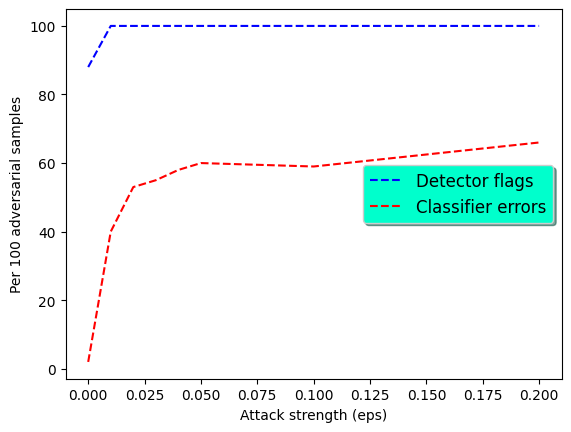

In [379]:
#SOLUTION

fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Per 100 adversarial samples')
plt.show()

## 3.2 Adversarial training
**Adversarial training** is a classical strategy to improve a model's robustness against attacks.  

The main idea is to **train the model not only on legitimate examples but also on adversarially perturbed examples**. By doing this, the model learns to correctly classify even when inputs are slightly manipulated.

In ART, this is implemented using the `AdversarialTrainer`, which automatically generates adversarial examples during training and includes them in each batch. This forces the model to adapt to adversarial perturbations and become more resistant to future attacks.


### Setup the classifiers
- Retrieve the classifier used for people/things and make a copy *robust_classifier* (for comparison purposes)
- Create a generator of advesarial examples based on PGD
- Create a *AdversarialTrainer* using the copy and the attack model as argument
- Launch a training with *fit* as usual => This is the actual adversarial training !

In [380]:
#TODO


In [381]:
#SOLUTION

model = load_model("./classifier.h5")
classifier = TensorFlowV2Classifier(clip_values=(min_, max_), model=model, \
    loss_object=CategoricalCrossentropy(), optimizer=Adam(), nb_classes=len(classes), \
    input_shape=x_train[0].shape, preprocessing=(0, 1)
)

x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_pred))

Original test data:
Correctly classified: 164
Incorrectly classified: 50


In [382]:
#SOLUTION

if LOAD_MODEL_ADV:
    robust_model = load_model("./robust_classifier.h5")
    classifier = TensorFlowV2Classifier(clip_values=(min_, max_), model=robust_model, \
        loss_object=CategoricalCrossentropy(), optimizer=Adam(), nb_classes=len(classes), \
        input_shape=x_train[0].shape, preprocessing=(0, 1)
    )


In [384]:
#SOLUTION

if not LOAD_MODEL_ADV:
    robust_model = load_model("./classifier.h5")
    robust_classifier = TensorFlowV2Classifier(clip_values=(min_, max_), model=robust_model, \
        loss_object=CategoricalCrossentropy(), optimizer=Adam(), nb_classes=len(classes), \
        input_shape=x_train[0].shape, preprocessing=(0, 1)
    )
    
    attack_pgd = ProjectedGradientDescent(estimator=robust_classifier, eps=0.03, max_iter=40)

    trainer = AdversarialTrainer(robust_classifier, attack_pgd, ratio=1.0)
    trainer.fit(x_train, y_train, nb_epochs=10, batch_size=128)

Adversarial training epochs: 100%|██████████| 10/10 [01:56<00:00, 11.69s/it]


In [385]:
if not LOAD_MODEL_ADV:
    trainer.classifier.model.save("./robust_classifier.h5")

### Compare the accuracy of the resulting model with the accuracy of the original model
Compute the accuracy of this classifier
- on the test set
- on adversarial examples generated using the previous attacker and a new one

In [386]:
#TODO


In [387]:
#SOLUTION

x_test_robust_pred = np.argmax(robust_classifier.predict(x_test), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_robust_pred))

Original test data:
Correctly classified: 168
Incorrectly classified: 46


In [388]:
#SOLUTION

attacker_robust = FastGradientMethod(trainer.classifier, eps=0.5)
x_test_adv_robust = attacker_robust.generate(x_test, y_test)

x_test_adv_robust_pred = np.argmax(trainer.classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test, axis=1))

print("Adversarial test data:")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(len(x_test_adv_robust)-nb_correct_adv_robust_pred))

Adversarial test data:
Correctly classified: 97
Incorrectly classified: 117


### Impact of epsilon
Without retraining your robust model:
- vary the value of epsilon between 0.01 and 0.9
- generate adversarial examples from the test set and the original and robust classifier
- plot the accuracy for both classifier

In [389]:
#TODO


In [390]:
#SOLUTION

attacker_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.5, eps_step=0.01, max_iter=200, verbose=False)
attacker_robust_pgd = ProjectedGradientDescent(estimator=robust_classifier, eps=0.5, eps_step=0.01, max_iter=200, verbose=False)

eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nb_correct_original = []
nb_correct_robust = []

nb_samples = 100

for eps in eps_range:
    attacker_pgd.set_params(**{'eps': eps})
    attacker_robust_pgd.set_params(**{'eps': eps})
    x_test_adv = attacker_pgd.generate(x_test[:nb_samples], y_test[:nb_samples])
    x_test_adv_robust = attacker_robust_pgd.generate(x_test[:nb_samples], y_test[:nb_samples])
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test[:nb_samples], axis=1)) / nb_samples]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:nb_samples], axis=1)) / nb_samples]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred / 10000] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred / 10000] + nb_correct_robust

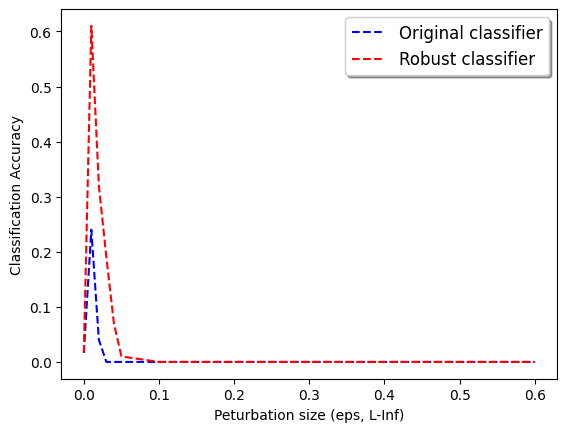

In [391]:
#SOLUTION

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper right', shadow=True, fontsize='large')

plt.xlabel('Peturbation size (eps, L-Inf)')
plt.ylabel('Classification Accuracy')
plt.show()